In [1]:
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from fbprophet import Prophet

# Prophet Model

Uses Facebook Prophet package to forecast speed of a single sensor using a decomposible time series model that takes into account many types of seasonality.

Read more: https://facebook.github.io/prophet/docs/quick_start.html#python-api



### Setup

In [2]:
station_meta = pd.read_csv('../data/processed/fwy_405_n_ds/meta.csv')

In [3]:
with open('../data/processed/fwy_405_n_ds/speeds.dat', 'rb') as f:
    station_data = pickle.load(f)

station_data.index = pd.to_datetime(station_data.index)

### Select Sensor

Choose sensor ID and split into train/test

In [4]:
# good example stations to try
#   717711  (difficult)
#   716659  (many random outliers)
#   761455  (periodic)
#   772455  (very periodic)

# select a station number to use
STATION = 772455


# use may, june as train data and july as test data
train_data = station_data[STATION][station_data.index < pd.to_datetime('2021-07-01')]
test_data = station_data[STATION][station_data.index >= pd.to_datetime('2021-07-01')]

### Model

In [5]:
# convert to fbprophet format
df = pd.DataFrame({'ds': train_data.index, 'y': train_data.values})
df.head()

# initialize model
m = Prophet(yearly_seasonality=False)
m.fit(df)

In [6]:
# predict test data
future = m.make_future_dataframe(periods=test_data.size, freq='5min')
forecast = m.predict(future)

preds = forecast.set_index('ds').loc[test_data.index]['yhat'].values

MAE:  7.116
RMSE: 10.294


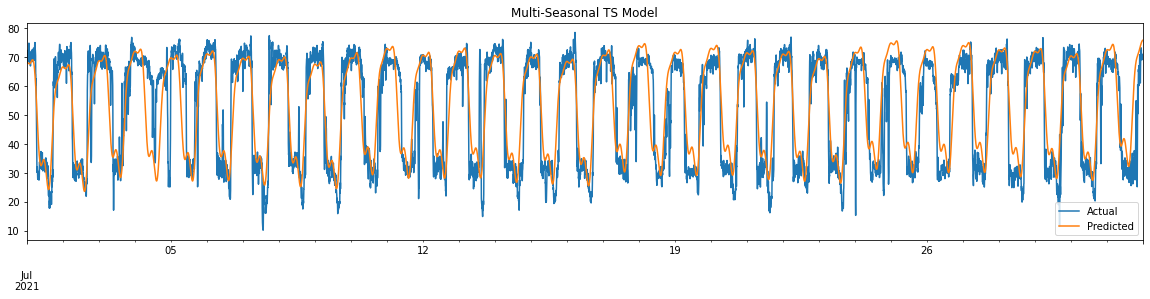

In [7]:
# results
print('MAE:  %.3f' % mean_absolute_error(test_data.values, preds))
print('RMSE: %.3f' % mean_squared_error(test_data.values, preds, squared=False))

p = pd.DataFrame(
    {'Actual': test_data.values, 'Predicted': preds}, 
    index=test_data.index 
).plot(figsize=(20,4), title='Multi-Seasonal TS Model')

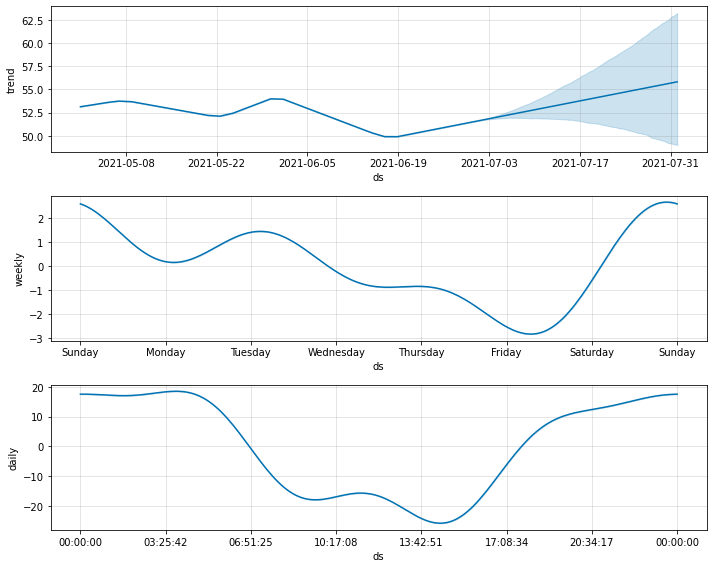

In [8]:
# model component
p = m.plot_components(forecast, figsize=(10, 8))